# Predicting TPSA of Chemical Compounds

Topological Polar Surface Area is important for understanding how a compound will behave in the body. Usually a TPSA of less than 140 is required for the compound to cross the cell membrane. Usually a TPSA of less than 90 is required for the compound to cross the blood brain barrier.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np

In [3]:
chem_df = pd.read_csv('../input/train_folds.csv')
chem_df.head()

,toxic,FormalCharge,TPSA,MolWt,HeavyAtoms,NHOH,HAcceptors,HDonors,Heteroatoms,AromaticRings,SaturatedRings,AromaticOH,AromaticN,LogP,kfold
0,0,1,46.53,332.464,24,1,3,1,4,1,2,1,0,2.8541,0
1,0,1,60.14,255.363,17,2,2,3,5,0,0,0,0,0.0079,0
2,0,-2,168.58,408.417,27,3,10,2,12,1,1,0,1,-2.7176,0
3,0,0,46.17,183.251,13,1,2,1,3,0,1,0,0,1.1278,0
4,0,0,772.17,1448.686,78,16,51,16,67,0,2,0,0,-19.3965,0


In [4]:
# check for missing values
chem_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   toxic           1460 non-null   int64  
 1   FormalCharge    1460 non-null   int64  
 2   TPSA            1460 non-null   float64
 3   MolWt           1460 non-null   float64
 4   HeavyAtoms      1460 non-null   int64  
 5   NHOH            1460 non-null   int64  
 6   HAcceptors      1460 non-null   int64  
 7   HDonors         1460 non-null   int64  
 8   Heteroatoms     1460 non-null   int64  
 9   AromaticRings   1460 non-null   int64  
 10  SaturatedRings  1460 non-null   int64  
 11  AromaticOH      1460 non-null   int64  
 12  AromaticN       1460 non-null   int64  
 13  LogP            1460 non-null   float64
 14  kfold           1460 non-null   int64  
dtypes: float64(3), int64(12)
memory usage: 171.2 KB


### Explore the type of data for each feature

In [5]:
# see how many unique values there are for each feature
chem_df.nunique()

toxic                2
FormalCharge        13
TPSA               898
MolWt             1338
HeavyAtoms          97
NHOH                26
HAcceptors          30
HDonors             22
Heteroatoms         43
AromaticRings        9
SaturatedRings      10
AromaticOH          13
AromaticN            8
LogP              1389
kfold                5
dtype: int64

In [6]:
def visualize_barplot(df, col):
    plt.figure(figsize=(8,4))
    val_counts = df[col].value_counts().reset_index()
    val_counts.columns = ['category', 'count']
    ax = sns.barplot(data=val_counts, x='category', y='count').set_title(f'{col.capitalize()} Value Counts', fontsize=15)
    plt.show()

In [7]:
# visualize the bar plots for all features that have less than 40 unique values
unique_vals = chem_df.nunique()
less_than_forty = list(unique_vals[unique_vals < 40].index)
less_than_forty.remove('kfold')

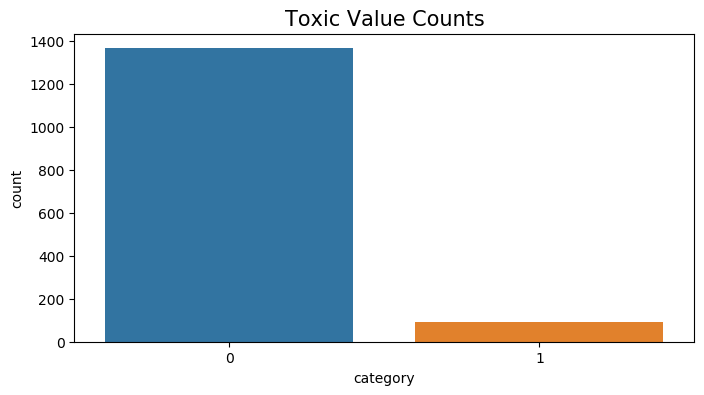

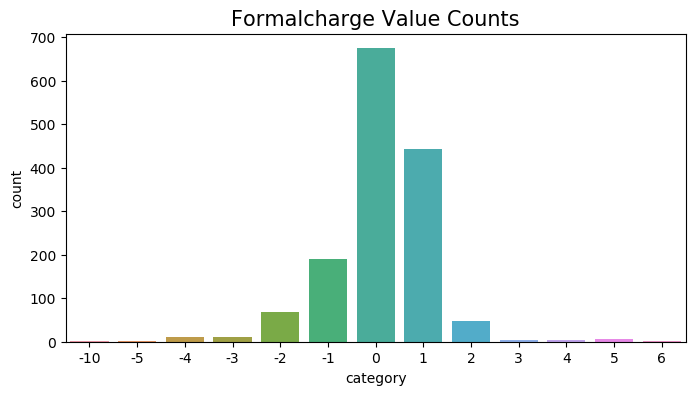

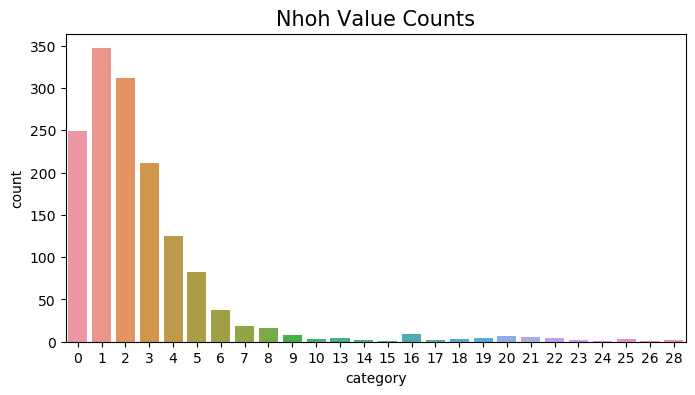

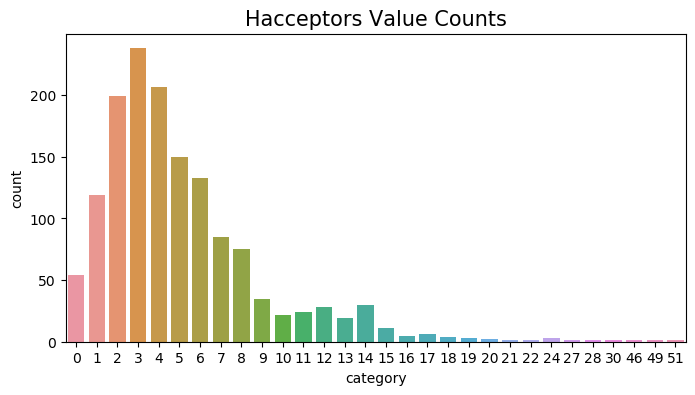

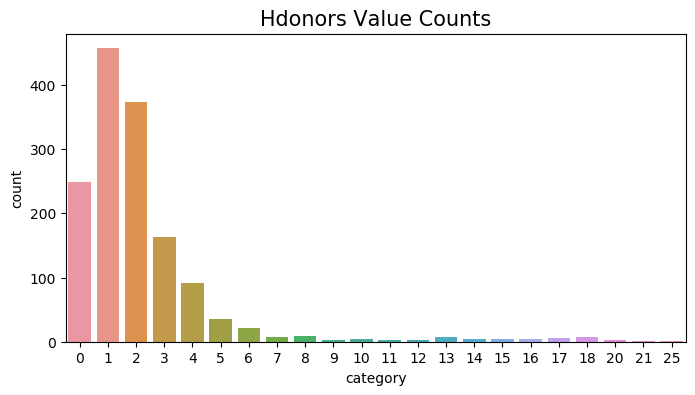

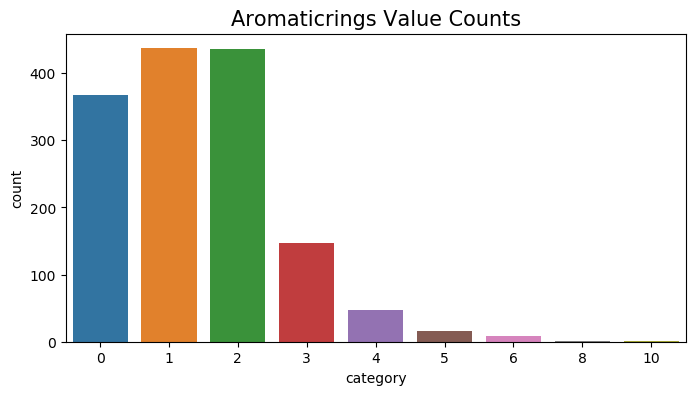

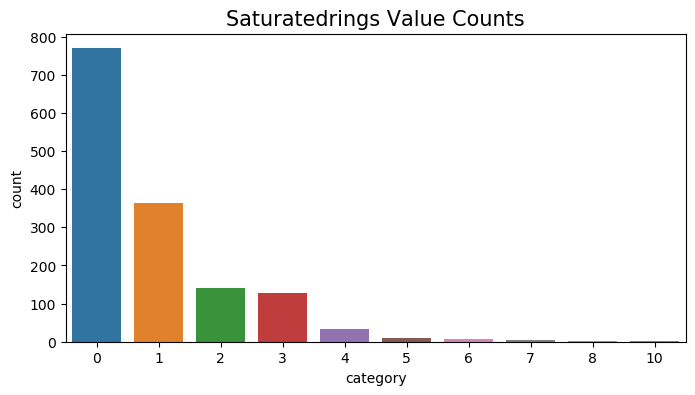

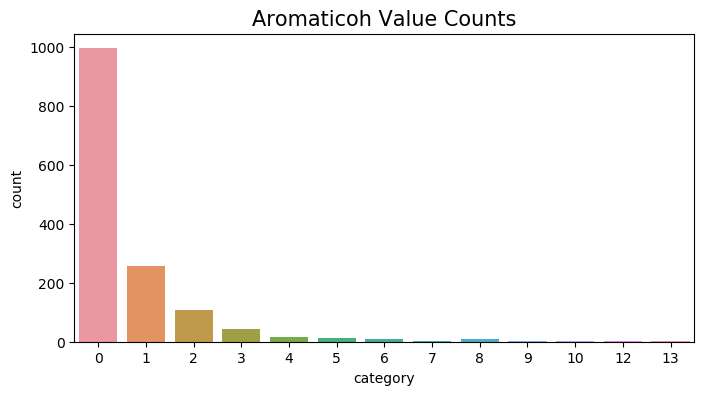

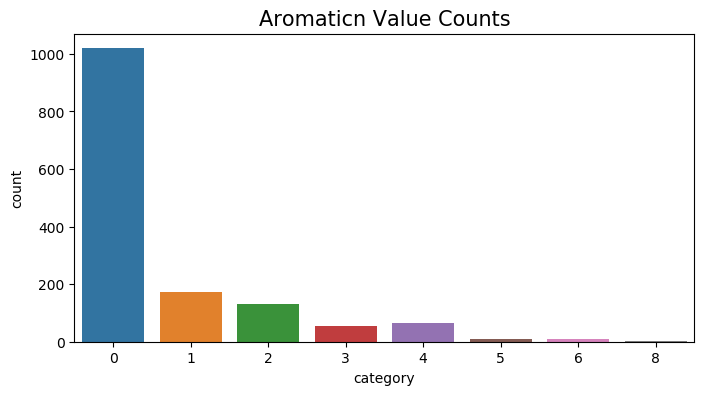

In [8]:
for feat in less_than_forty:
    visualize_barplot(chem_df, feat)

In [9]:
#visualize all the other features using histogram
hist_cols = [col for col in chem_df.columns if col not in less_than_forty and col != 'kfold'] 

In [10]:
hist_cols

['TPSA', 'MolWt', 'HeavyAtoms', 'Heteroatoms', 'LogP']

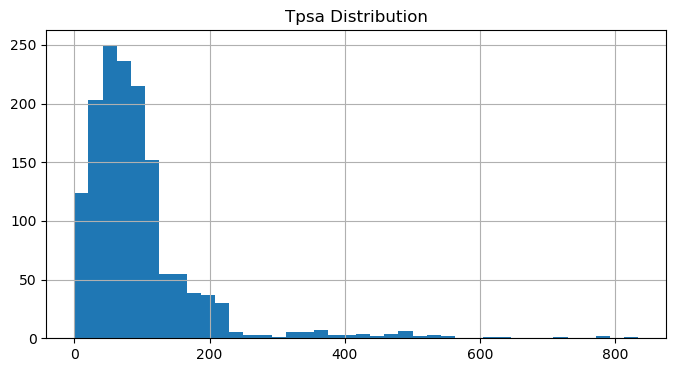

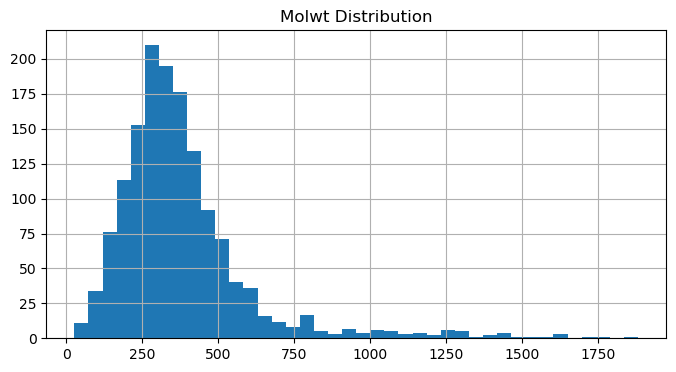

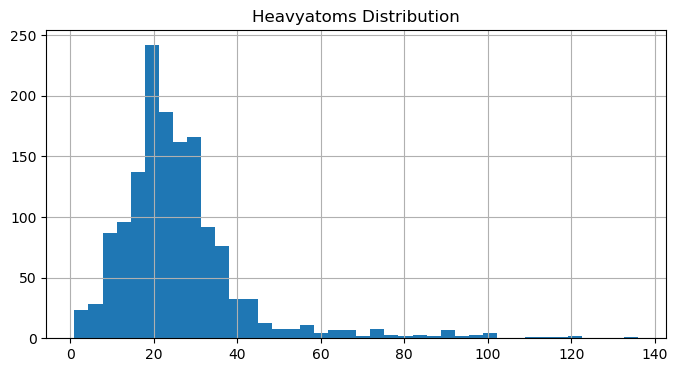

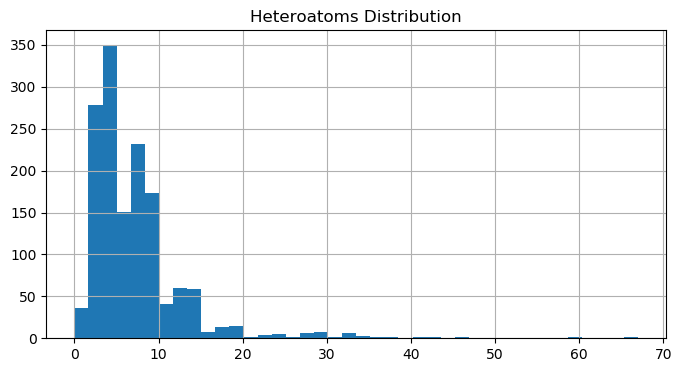

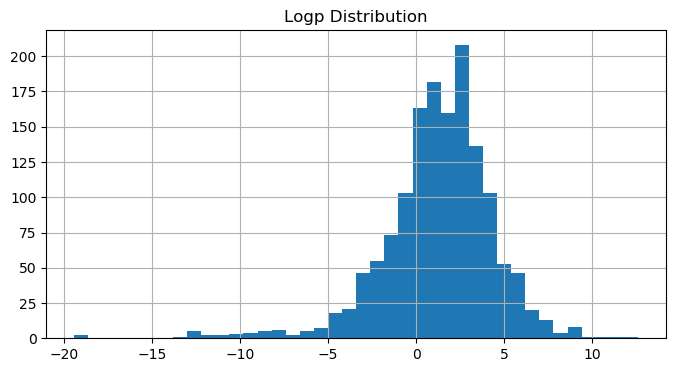

In [11]:
for col in hist_cols:
    chem_df[col].hist(figsize=(8, 4), bins=40, xlabelsize=10, ylabelsize=10)
    plt.title(f'{col.capitalize()} Distribution')
    plt.show()

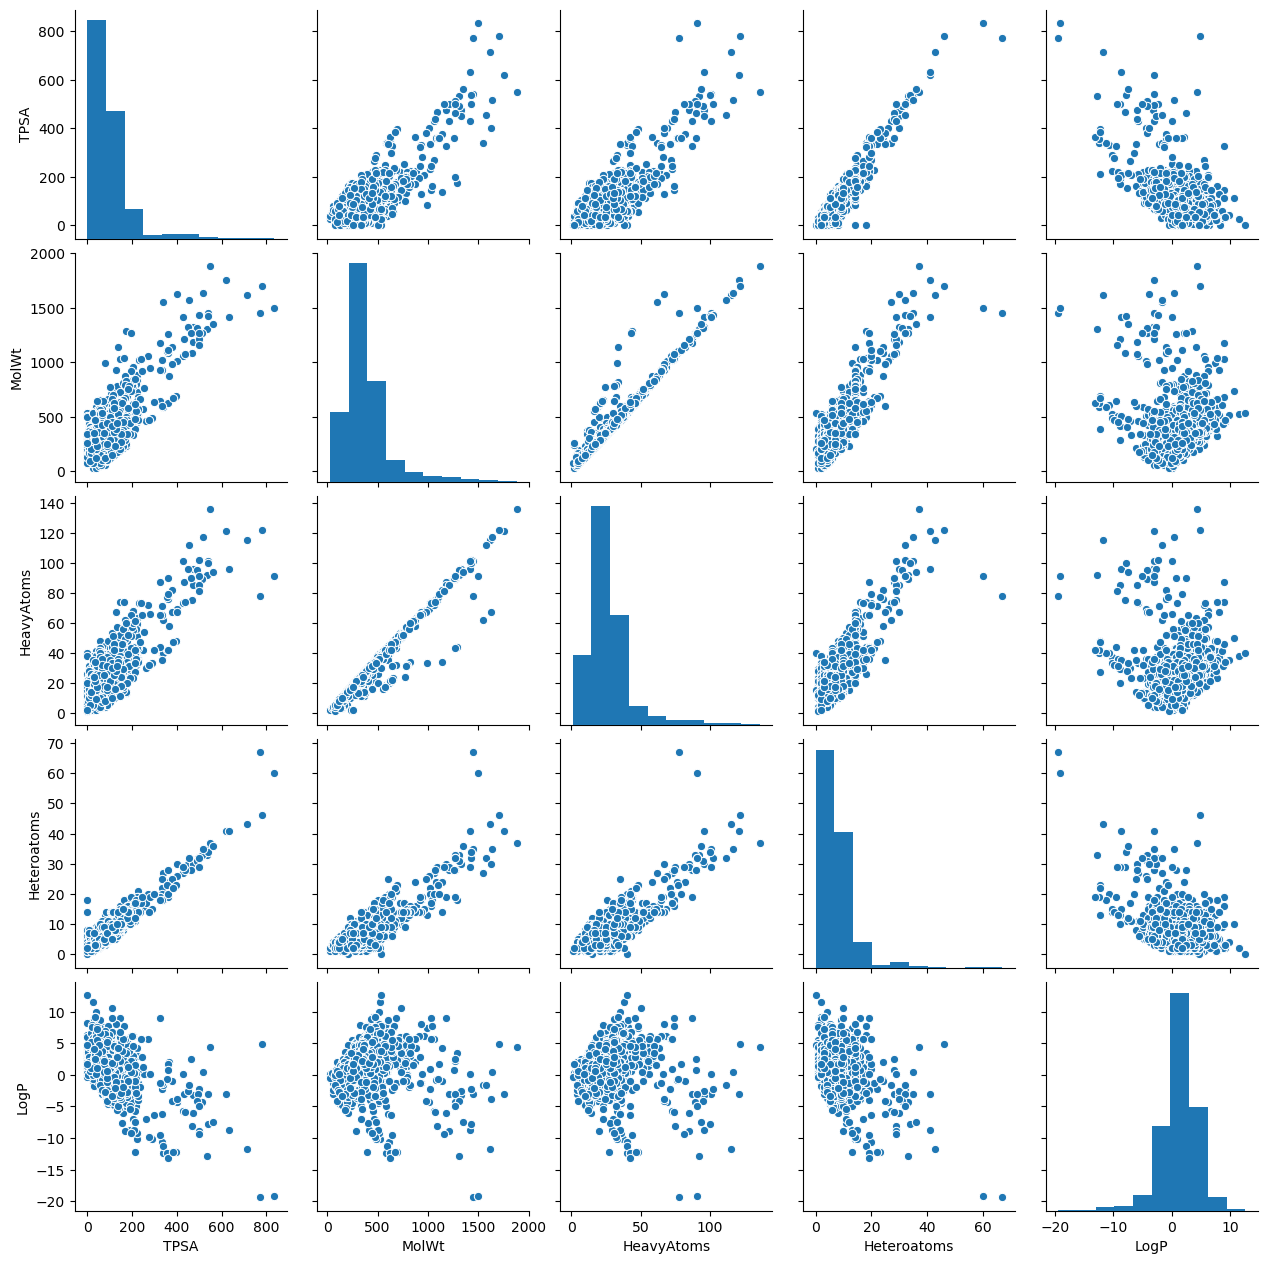

In [12]:
# look at pairplot of the continuous features
sns.pairplot(chem_df[hist_cols], markers="o")
plt.show()

### Molecular Weight is highly correlated to a lot of the features

## Try transforming the data with Yeo Johnson transformation

Severe skewed data

In [18]:
from sklearn.preprocessing import PowerTransformer

In [35]:
def yeo_johnson_transform(df, col):

    pt = PowerTransformer(method='yeo-johnson')
    data = np.array(df[col]).reshape(-1, 1)
    pt.fit(data)
    print(f'Feature:{col} , Lambda value: {pt.lambdas_[0]}')

    transformed_data = pt.transform(data)
    
    return transformed_data


In [36]:
tran_df = pd.DataFrame(index=chem_df.index)

for col in hist_cols:
    
    tran_data = yeo_johnson_transform(chem_df, col)
    temp_df = pd.DataFrame(tran_data, columns=[f'{col}_tran'])
    tran_df = tran_df.join(temp_df)
    
tran_df.head()

Feature:TPSA , Lambda value: 0.26469158357899725
Feature:MolWt , Lambda value: 0.061608618014589805
Feature:HeavyAtoms , Lambda value: 0.15307135794355883
Feature:Heteroatoms , Lambda value: -0.14340387545239627
Feature:LogP , Lambda value: 1.2035353931207422


,TPSA_tran,MolWt_tran,HeavyAtoms_tran,Heteroatoms_tran,LogP_tran
0,-0.527676,-0.018545,0.062475,-0.579771,0.455284
1,-0.252542,-0.516886,-0.558885,-0.242604,-0.551494
2,1.070253,0.376008,0.284186,1.093219,-1.245051
3,-0.535701,-1.131551,-1.013588,-1.004609,-0.186755
4,3.832704,2.920322,2.502501,3.499471,-4.314118


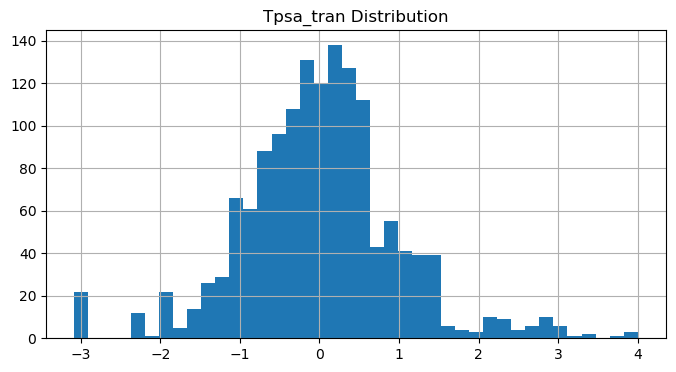

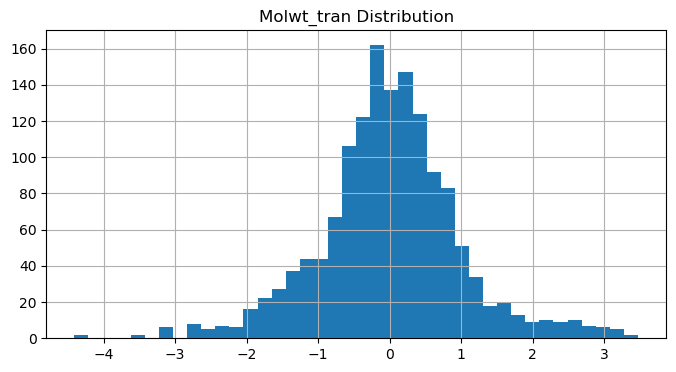

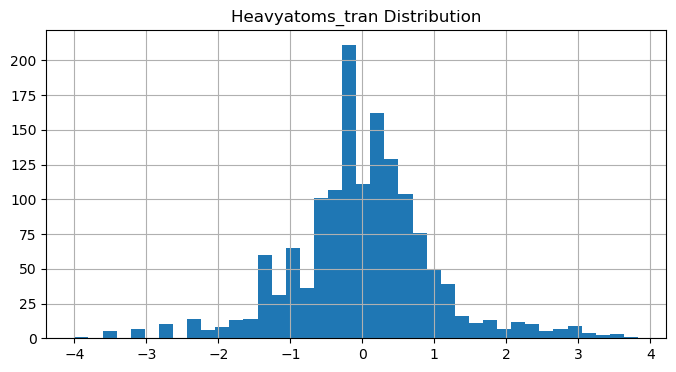

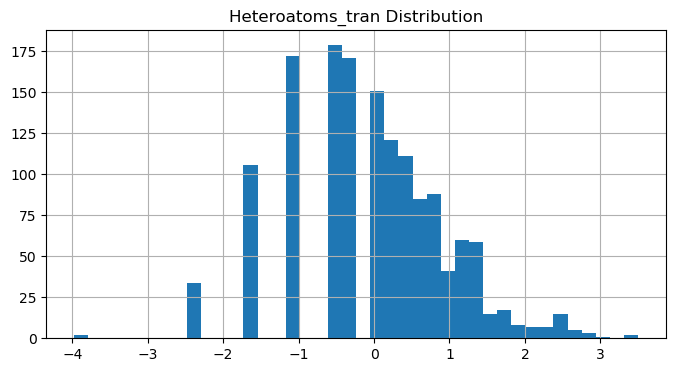

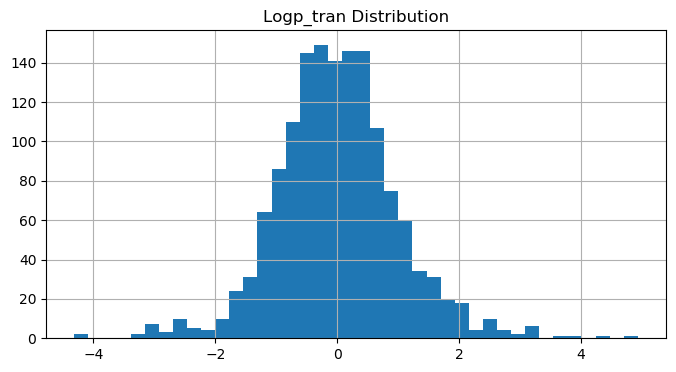

In [37]:
for col in tran_df.columns:
    tran_df[col].hist(figsize=(8, 4), bins=40, xlabelsize=10, ylabelsize=10)
    plt.title(f'{col.capitalize()} Distribution')
    plt.show()

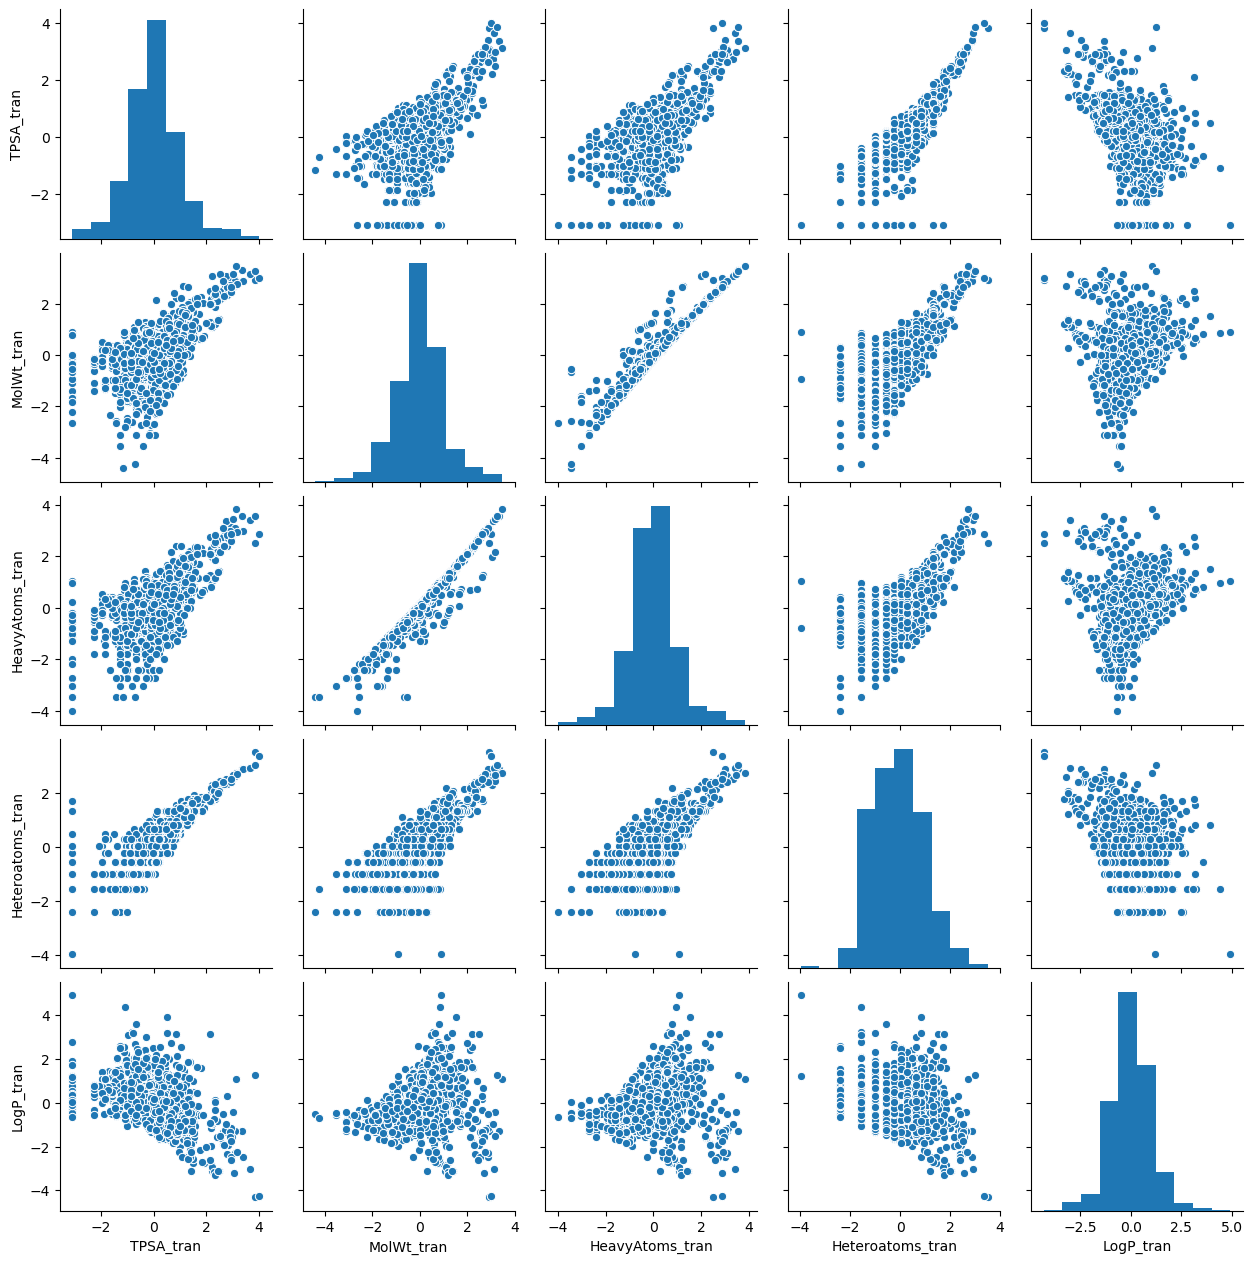

In [38]:
# look at pairplot of the continuous features
sns.pairplot(tran_df, markers="o")
plt.show()

## Add Transformed Data back to the categorical features

In [79]:
non_hist_cols = [col for col in  chem_df.columns if col not in hist_cols]
remove_tpsa = [col for col in tran_df.columns if col != 'TPSA_tran']
full_tran_df = chem_df[non_hist_cols].join(tran_df[remove_tpsa])
full_tran_df.columns

Index(['toxic', 'FormalCharge', 'NHOH', 'HAcceptors', 'HDonors',
       'AromaticRings', 'SaturatedRings', 'AromaticOH', 'AromaticN', 'kfold',
       'MolWt_tran', 'HeavyAtoms_tran', 'Heteroatoms_tran', 'LogP_tran'],
      dtype='object')

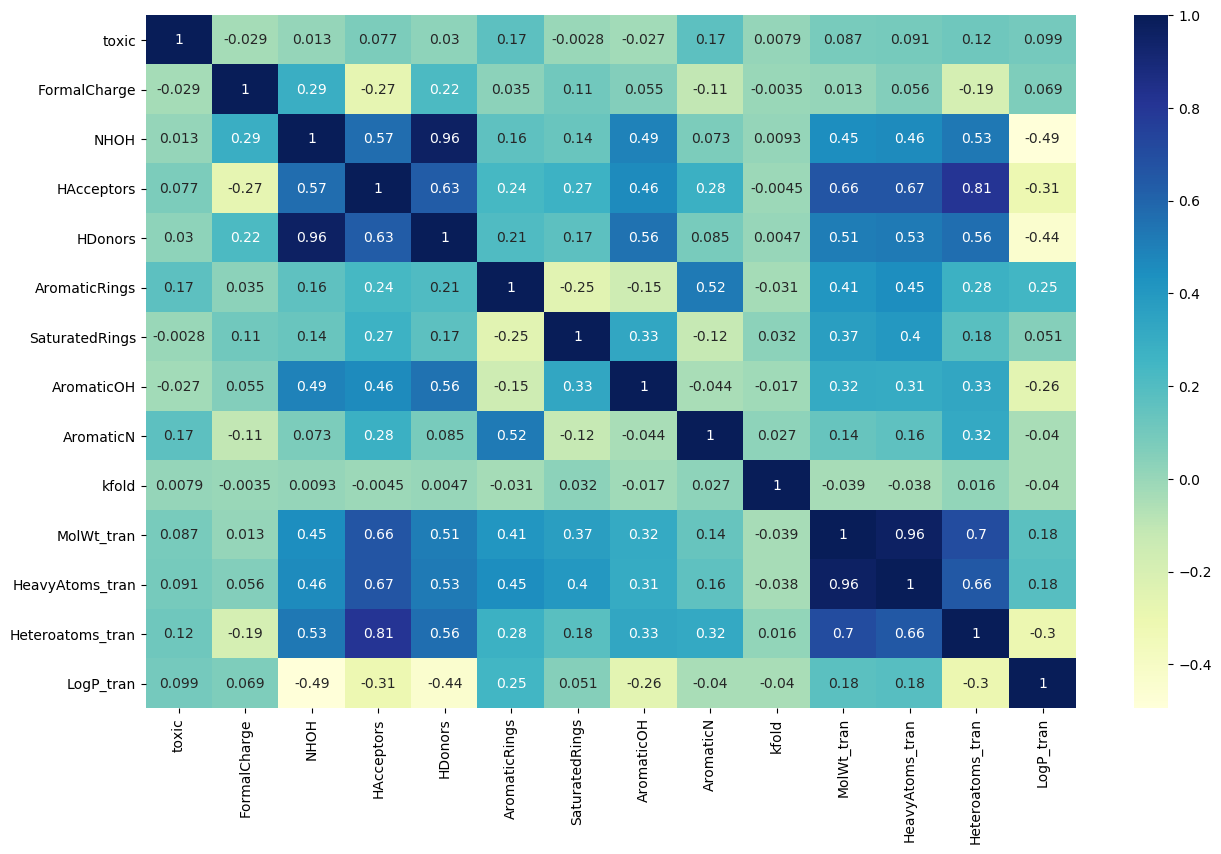

In [80]:
plt.figure(figsize=(15, 9))
sns.heatmap(full_tran_df.corr(), annot=True, cmap="YlGnBu")
plt.show()

## Filter out all predictors with correlation above 0.75

Check the average correlation of the high correlation features and drop the largest value feature

- HDonors vs NHOH
- MolWt_tran vs HeavyAtoms_tran
- Hacceptors vs Heteroatoms_tran

In [82]:
corr_df = full_tran_df.corr()
molwt_corr = corr_df['MolWt_tran'].mean()
heavyatoms_corr = corr_df['HeavyAtoms_tran'].mean()
print(f'MolWt average correlation: {molwt_corr}')
print(f'HeavyAtoms average correlation: {heavyatoms_corr}')

MolWt average correlation: 0.41090923944580665
HeavyAtoms average correlation: 0.4207011602969376


## MolWt wins out slightly over HeavyAtoms for a lower cross correlation and HeavyAtoms will be dropped from the data

In [87]:
full_tran_df = full_tran_df.drop(columns=['HeavyAtoms_tran'])

In [88]:
corr_df = full_tran_df.corr()
hdonors_corr = corr_df['HDonors'].mean()
nhoh_corr = corr_df['NHOH'].mean()
print(f'HDonors average correlation: {hdonors_corr}')
print(f'NHOH average correlation: {nhoh_corr}')

HDonors average correlation: 0.34621533034134405
NHOH average correlation: 0.32234110115694226


### NHOH wins out over HDonors and so HDonors will be dropped from the data

In [89]:
full_tran_df = full_tran_df.drop(columns=['HDonors'])

In [90]:
corr_df = full_tran_df.corr()
hacceptors_corr = corr_df['HAcceptors'].mean()
heteroatoms_corr = corr_df['Heteroatoms_tran'].mean()
print(f'HAcceptors average correlation: {hacceptors_corr}')
print(f'Heteroatoms average correlation: {heteroatoms_corr}')

HAcceptors average correlation: 0.3152080030389136
Heteroatoms average correlation: 0.3166925047177851


### HAcceptors slightly wins out over Heteroatoms so Heteroatoms will be dropped from the data

In [91]:
full_tran_df = full_tran_df.drop(columns=['Heteroatoms_tran'])

In [92]:
full_tran_df.head()

,toxic,FormalCharge,NHOH,HAcceptors,AromaticRings,SaturatedRings,AromaticOH,AromaticN,kfold,MolWt_tran,LogP_tran
0,0,1,1,3,1,2,1,0,0,-0.018545,0.455284
1,0,1,2,2,0,0,0,0,0,-0.516886,-0.551494
2,0,-2,3,10,1,1,0,1,0,0.376008,-1.245051
3,0,0,1,2,0,1,0,0,0,-1.131551,-0.186755
4,0,0,16,51,0,2,0,0,0,2.920322,-4.314118


In [96]:
# add back in the transformed TPSA column
preprocessed_df = full_tran_df.join(tran_df['TPSA_tran'])
preprocessed_df.head()

,toxic,FormalCharge,NHOH,HAcceptors,AromaticRings,SaturatedRings,AromaticOH,AromaticN,kfold,MolWt_tran,LogP_tran,TPSA_tran
0,0,1,1,3,1,2,1,0,0,-0.018545,0.455284,-0.527676
1,0,1,2,2,0,0,0,0,0,-0.516886,-0.551494,-0.252542
2,0,-2,3,10,1,1,0,1,0,0.376008,-1.245051,1.070253
3,0,0,1,2,0,1,0,0,0,-1.131551,-0.186755,-0.535701
4,0,0,16,51,0,2,0,0,0,2.920322,-4.314118,3.832704


In [98]:
# save the file for processing
preprocessed_df.to_csv( '../data/transformed_data.csv')